<a href="https://colab.research.google.com/github/gbaghdadi/NeuromatchDeepLearningProject/blob/main/NMAproject2023_PytorchRegression_StringerData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.model_selection import KFold


In [2]:
# @title NMA Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
# @title NMA Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [4]:
# @title NMA Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [5]:
# @title Shape of each data

print('neuralActivity dimension:   ', dat['sresp'].shape)
print('stat dimension:  ', dat['stat'].shape)
print('running speed dimension:  ', dat['run'].shape)
print('pupil area dimension:  ', dat['pupilArea'].shape)
print('pupil xy position dimension:  ', dat['pupilCOM'].shape)
print('faceSVD dimension:   ',dat['beh_svd_time'].shape)

neuralActivity dimension:    (11983, 7018)
stat dimension:   (11983, 1)
running speed dimension:   (7018, 1)
pupil area dimension:   (7018, 1)
pupil xy position dimension:   (7018, 2)
faceSVD dimension:    (7018, 1000)


In [6]:
# @title Input and Output of the Model

neural_activity = dat['sresp']    # Input
run_speed = dat['run']            # Output
pupil_area = dat['pupilArea']     # Output

print('Input dimension:  ', neural_activity.shape)
print('Output dimension:  ',run_speed.shape)

Input dimension:   (11983, 7018)
Output dimension:   (7018, 1)


In [7]:
# reshaping input and output
neural_activity = np.transpose(neural_activity)
runspeed = run_speed.squeeze()
pupilarea = pupil_area.squeeze()
print('Input dimension:  ', neural_activity.shape)
print('Output dimension:  ',runspeed.shape)

Input dimension:   (7018, 11983)
Output dimension:   (7018,)


In [8]:
# @title Dimension Reduction of the Input using PCA
pca_model = PCA(n_components=500)
reduced = pca_model.fit_transform(neural_activity)
component = pca_model.components_
neural_activity = reduced
print(neural_activity.shape)
# print(component.shape)

(7018, 500)


#Pytorch Regression Model: neural activity -> running speed

adapted from "https://machinelearningmastery.com/building-a-regression-model-in-pytorch/"

In [9]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()
print(data.feature_names)

X, y = data.data, data.target
print(X.shape)
print(y.shape)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
(20640, 8)
(20640,)


In [17]:
X = neural_activity
y = runspeed
print(X.shape)
print(y.shape)

(7018, 500)
(7018,)


In [18]:
import torch.nn as nn

# Define the model
model = nn.Sequential(
    nn.Linear(500, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

In [19]:
import torch.nn as nn
import torch.optim as optim

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [21]:
import copy
import numpy as np
import torch
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# train-test split of the dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# train-test split for model evaluation
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)#.reshape(-1, 1)
y_train = torch.tensor(y_train, dtype=torch.float32)#.reshape(-1, 1)



print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# training parameters
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)

torch.Size([4912, 500])
torch.Size([4912])
torch.Size([2106, 500])
torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

<All keys matched successfully>

MSE: 76.87
RMSE: 8.77


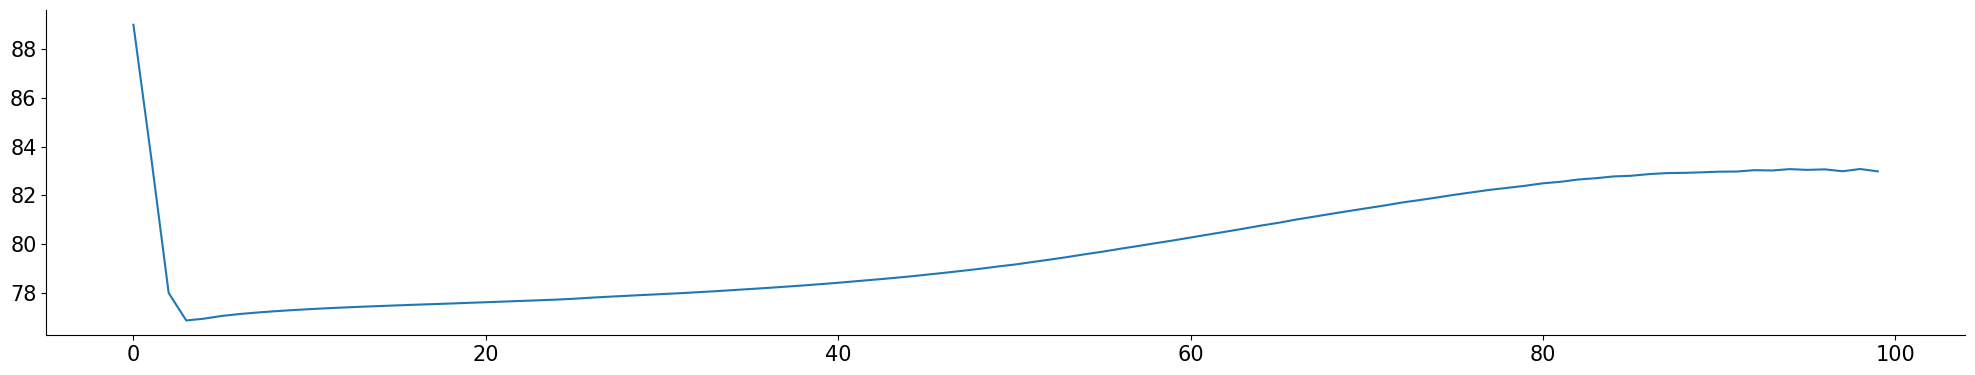

In [22]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

torch.Size([2106, 1])
torch.Size([2106])


(0.0, 46.49553298950195)

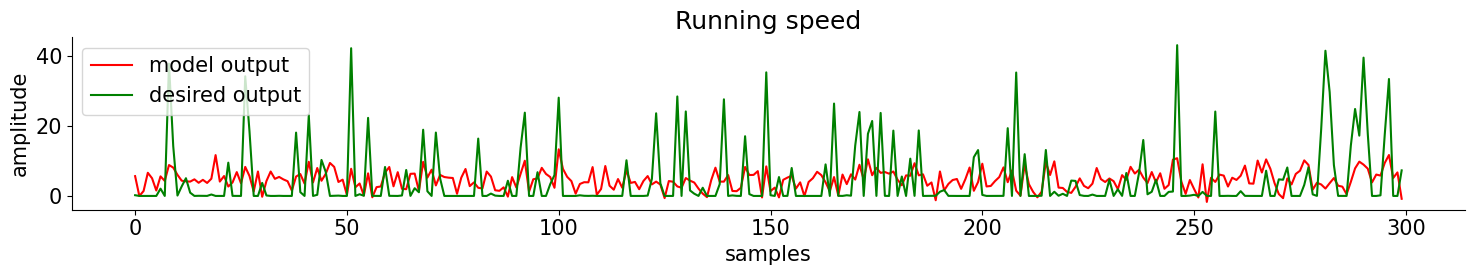

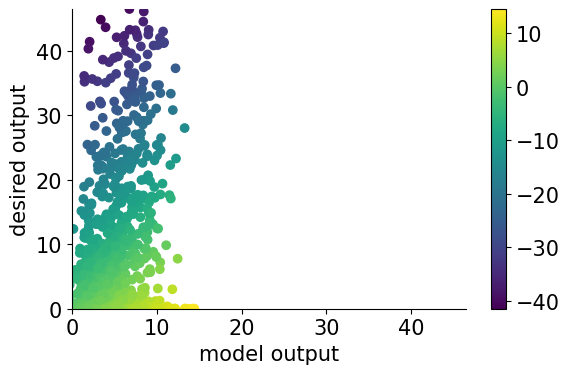

In [34]:
# @title Results of linear decoding of running speed
print(y_pred.shape)
print(y_test.shape)
plt.figure(figsize=(15,3))
plt.plot(y_pred[0:300].detach().numpy(), color = 'r', label = "model output")
plt.plot(y_test[0:300].detach().numpy(), color = 'g', label = "desired output")
plt.legend()
plt.xlabel("samples")
plt.ylabel("amplitude")
plt.title('Running speed')

plt.figure(figsize=(6,4))
err = y_pred.detach().numpy().squeeze() - y_test.detach().numpy()
plt.scatter(y_pred.detach().numpy(), y_test.detach().numpy(), c=err)
plt.xlabel("model output")
plt.ylabel("desired output")
plt.colorbar()
plt.xlim((0, np.max([y_pred.detach().numpy().squeeze(), y_test.detach().numpy()])))
plt.ylim((0, np.max([y_pred.detach().numpy().squeeze(), y_test.detach().numpy()])))

MSE: 0.48
RMSE: 0.69


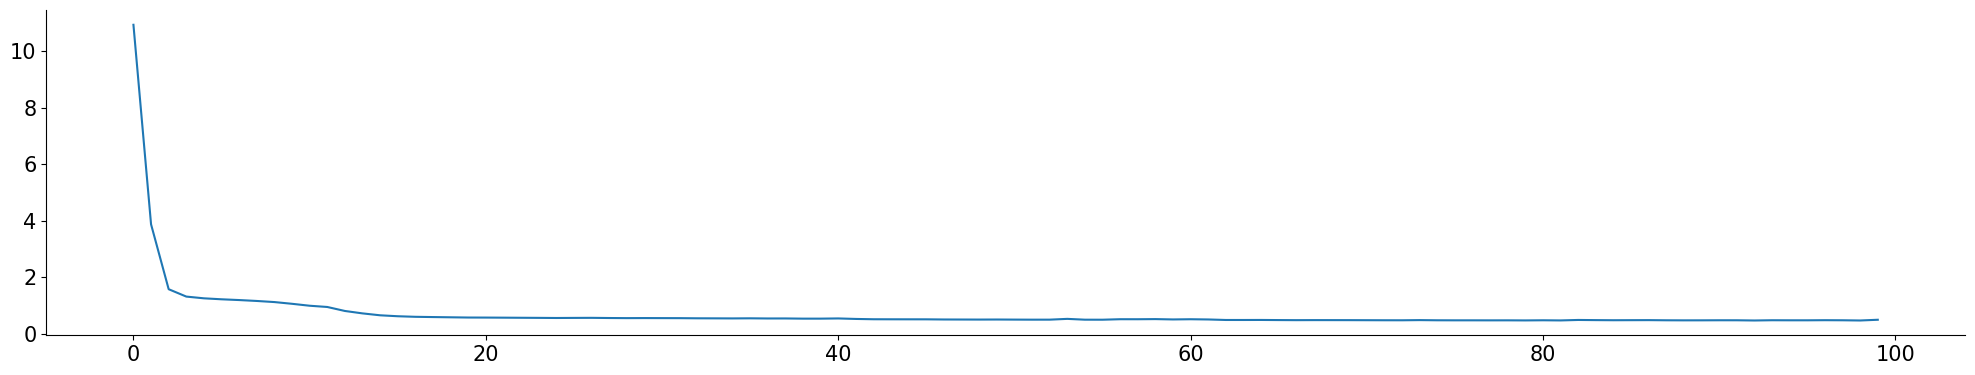

In [15]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing

# Read data
data = fetch_california_housing()
X, y = data.data, data.target

# train-test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# Define the model
model = nn.Sequential(
    nn.Linear(8, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()